# 1. Data Preparation

In [ ]:
# Library To Upload File
from google.colab import files

In [ ]:
#Upload Kaggle API (Kaggle.json)
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
#Install Kaggle
!pip install -q kaggle

In [ ]:
# Make A Space For Data
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

## This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%time
# Download Dataset
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

100% 1.98G/1.98G [00:15<00:00, 184MB/s]
100% 1.98G/1.98G [00:15<00:00, 141MB/s]
CPU times: user 298 ms, sys: 64.3 ms, total: 362 ms
Wall time: 16 s


In [ ]:
%%time
# Unzip dataset
!unzip fruit-and-vegetable-image-recognition.zip -d dataset

# 2. Dataset Overview

In [ ]:
import os
import matplotlib.pyplot as plt

In [ ]:
#Divide to 3  path
train_path = "/content/dataset/train"
validation_path = "/content/dataset/validation"
test_path  = "/content/dataset/test"

In [ ]:
label = [_ for _ in os.listdir(train_path)]
label.sort()
#label

In [ ]:
def generate_path(xxx_path):
  list_path = []
  for i in label:
    folder = os.path.join(xxx_path,i)
    for name in os.listdir(folder):
      file = os.path.join(folder,name)
      list_path.append(file)
  return list_path

In [ ]:
list_train = generate_path(train_path)
list_validation = generate_path(validation_path)
list_test = generate_path(test_path)

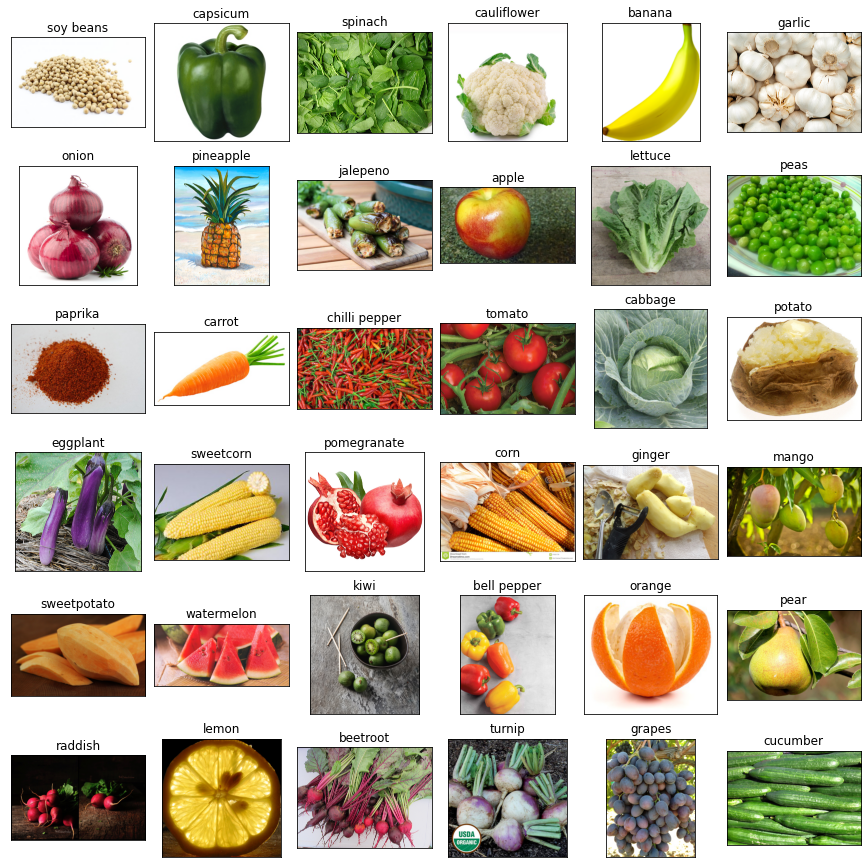

In [ ]:
#Make Display Shape
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(12,12),
                        subplot_kw={'xticks': [], 'yticks': []})

#Make All data can showed
show_path = []
for i in label:
  folder = os.path.join(train_path,i)
  name = os.listdir(folder)[label.index(i)]
  file = os.path.join(folder,name)
  show_path.append(file)

#Arrange the show path
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(show_path[i]))
    ax.set_title(label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# 3. Building Model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

print(tf.__version__)

2.4.1


In [ ]:
#Using RSP Model (1.0.0)
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(128, (3,3), input_shape=(150, 150, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The Second convolution
    tf.keras.layers.Conv2D(128, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(5,5),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(36, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 70, 128)       409728    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

In [ ]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras_preprocessing.image import ImageDataGenerator as IDG

#Augmentation
training_dataAug = IDG(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
      )

validation_dataAug = IDG(rescale = 1./255)

train_generator = training_dataAug.flow_from_directory(
	train_path,
  color_mode='rgb',
  shuffle=True,
  seed=0,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=32
)

validation_generator = validation_dataAug.flow_from_directory(
	validation_path,
	color_mode='rgb',
  shuffle=True,
  seed=0,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=32
)


Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.


In [ ]:
#Train Model
history = model.fit(
    train_generator, 
    epochs=15, 
    batch_size = 32, 
    validation_data = validation_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ])

Epoch 1/15
 3/98 [..............................] - ETA: 1:53 - loss: 0.2418 - accuracy: 0.9167

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 5/98 [>.............................] - ETA: 2:10 - loss: 0.2413 - accuracy: 0.9187

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


98/98 [==============================] - 145s 1s/step - loss: 0.3037 - accuracy: 0.9040 - val_loss: 0.2396 - val_accuracy: 0.9630
Epoch 2/15
98/98 [==============================] - 142s 1s/step - loss: 0.2665 - accuracy: 0.9185 - val_loss: 0.2517 - val_accuracy: 0.9573
Epoch 3/15
98/98 [==============================] - 143s 1s/step - loss: 0.2290 - accuracy: 0.9332 - val_loss: 0.2299 - val_accuracy: 0.9715
Epoch 4/15
98/98 [==============================] - 144s 1s/step - loss: 0.2439 - accuracy: 0.9246 - val_loss: 0.2243 - val_accuracy: 0.9658
Epoch 5/15
98/98 [==============================] - 144s 1s/step - loss: 0.1803 - accuracy: 0.9474 - val_loss: 0.2360 - val_accuracy: 0.9573
Epoch 6/15
98/98 [==============================] - 147s 1s/step - loss: 0.1910 - accuracy: 0.9416 - val_loss: 0.2759 - val_accuracy: 0.9687


# 4. Plotting the training and validation accuracy

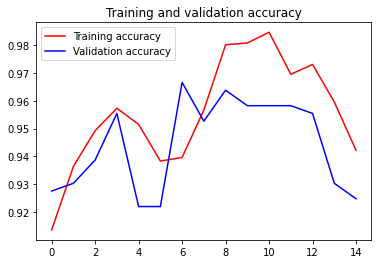

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# 5. Test Model

In [ ]:
y_true = []
for name in list_test:
    unique = os.path.join(test_path,name)
    exact = list_test.index(name)
    for i in os.listdir(unique):
        y_true.append(exact)
        
#y_true

In [ ]:
#Predict List Test
pred = model.predict(list_test)
pred = np.argmax(pred,axis=1)

# Cek Result
ans = [label[i] for i in pred]
c = 0
for i in ans:
    print(f"Predict : {i}, \t Real Value : {label[y_true[c]]} ", end="")
    if(i==label[y_true[c]]):
        print("\tTRUE")
    else:
        print("\tFALSE")
    c += 1

Predict : cauliflower, 	 Real Value : apple 	FALSE
Predict : apple, 	 Real Value : apple 	TRUE
Predict : apple, 	 Real Value : apple 	TRUE
Predict : watermelon, 	 Real Value : apple 	FALSE
Predict : apple, 	 Real Value : apple 	TRUE
Predict : apple, 	 Real Value : apple 	TRUE
Predict : apple, 	 Real Value : apple 	TRUE
Predict : apple, 	 Real Value : apple 	TRUE
Predict : apple, 	 Real Value : apple 	TRUE
Predict : beetroot, 	 Real Value : apple 	FALSE
Predict : banana, 	 Real Value : banana 	TRUE
Predict : apple, 	 Real Value : banana 	FALSE
Predict : banana, 	 Real Value : banana 	TRUE
Predict : banana, 	 Real Value : banana 	TRUE
Predict : banana, 	 Real Value : banana 	TRUE
Predict : banana, 	 Real Value : banana 	TRUE
Predict : banana, 	 Real Value : banana 	TRUE
Predict : banana, 	 Real Value : banana 	TRUE
Predict : ginger, 	 Real Value : banana 	FALSE
Predict : beetroot, 	 Real Value : beetroot 	TRUE
Predict : beetroot, 	 Real Value : beetroot 	TRUE
Predict : beetroot, 	 Real V

# 5. Saving the model into .TFLite format

In [ ]:
import pathlib

In [ ]:
export_dir = 'fv_saved_model'
tf.saved_model.save(model, export_dir)

In [ ]:
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)